In [9]:
pip install ortools==9.10.4067


   ---------------------------------------- 0.0/130.2 MB ? eta -:--:--
   ---------------------------------------- 0.5/130.2 MB 8.5 MB/s eta 0:00:16
    --------------------------------------- 1.8/130.2 MB 6.7 MB/s eta 0:00:20
    --------------------------------------- 2.9/130.2 MB 5.6 MB/s eta 0:00:23
    --------------------------------------- 3.1/130.2 MB 5.8 MB/s eta 0:00:23
    --------------------------------------- 3.1/130.2 MB 5.8 MB/s eta 0:00:23
   - -------------------------------------- 4.2/130.2 MB 3.8 MB/s eta 0:00:34
   - -------------------------------------- 4.2/130.2 MB 3.8 MB/s eta 0:00:34
   - -------------------------------------- 4.7/130.2 MB 2.9 MB/s eta 0:00:43
   - -------------------------------------- 5.2/130.2 MB 3.2 MB/s eta 0:00:40
   - -------------------------------------- 6.3/130.2 MB 3.3 MB/s eta 0:00:38
   -- ------------------------------------- 7.3/130.2 MB 3.4 MB/s eta 0:00:37
   -- ------------------------------------- 8.4/130.2 MB 3.5 MB/s eta 0


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
%pip install tabulate


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Tải dữ liệu thành công.
Dữ liệu tối ưu hóa ban đầu (đã chuẩn hóa) có shape: (46536, 7)
Dữ liệu sau khi un-scale (giả lập) và lọc sản phẩm:
       product_id  week            product_name  department_id  aisle_id  \
12363       13176    12  Bag of Organic Bananas              4        24   
12364       13176    13  Bag of Organic Bananas              4        24   
12365       13176    14  Bag of Organic Bananas              4        24   
12366       13176    15  Bag of Organic Bananas              4        24   
23260       24852    12                  Banana              4        24   

       predicted_scaled  actual_scaled  demand_forecast  demand_actual  
12363          3.835633       4.092340              692            864  
12364          3.533866       3.112613              632            668  
12365          2.591564       2.364961              444            519  
12366          0.975656       0.203759              120             87  
23260          3.523005       3.102064 

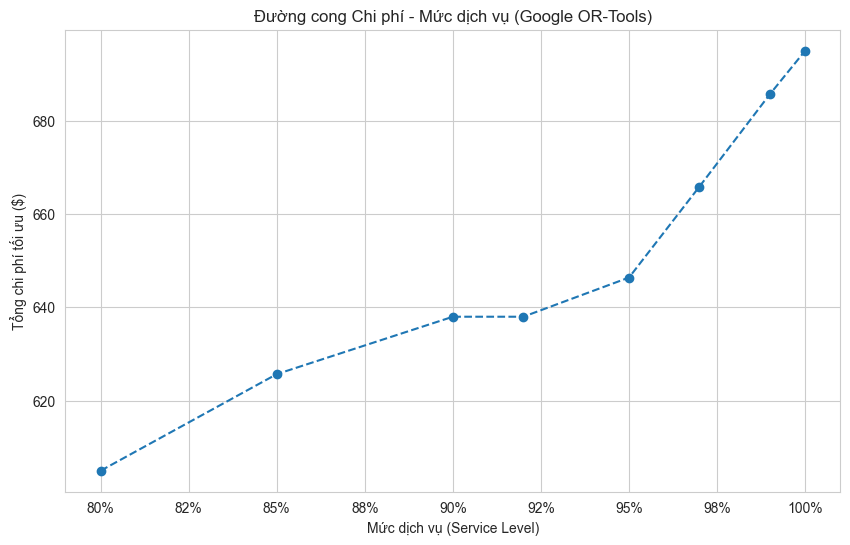

Hoàn thành mô phỏng so sánh.
So sánh chi phí (mô phỏng trên nhu cầu thực tế):
|                        |   Baseline Cost |   Forecast-Driven Cost (SL=95%) |
|:-----------------------|----------------:|--------------------------------:|
| Bag of Organic Bananas |          731.85 |                           368.8 |
| Banana                 |          662.5  |                           365   |


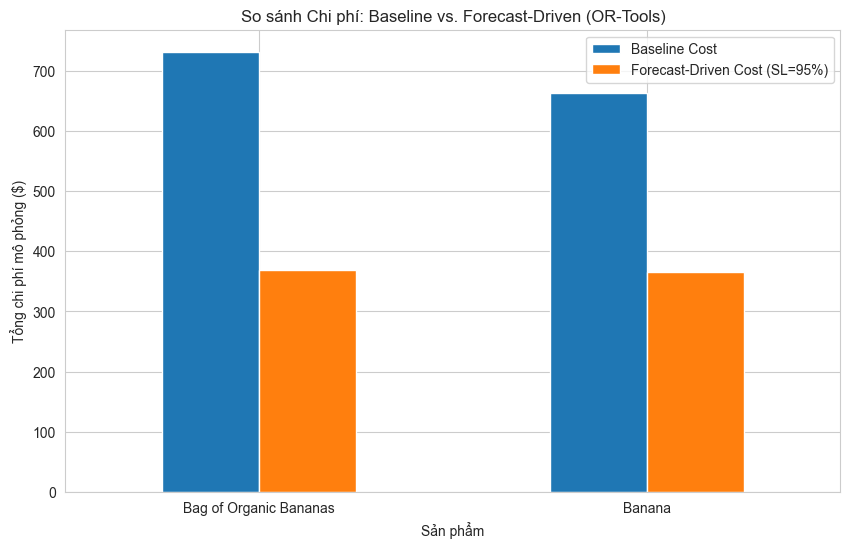

In [18]:
# ==========================================
# 4. Tối ưu hóa Tồn kho (Sử dụng Google OR-Tools)
# ==========================================

# 1. Cài đặt và import thư viện
# !pip install ortools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
from ortools.linear_solver import pywraplp

sns.set_style('whitegrid')

# ==========================================
# 1. Tải và Chuẩn bị Dữ liệu
# ==========================================

DATA_DIR = '../data'
RESULTS_DIR = '../results'

try:
    demand_df = pd.read_csv(os.path.join(DATA_DIR, 'demand_data.csv'))
    predictions_df = pd.read_csv(os.path.join(RESULTS_DIR, 'predictions.csv'))
    print("Tải dữ liệu thành công.")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file demand_data.csv hoặc predictions.csv.")
    print("Vui lòng chạy notebook 2 và 3 trước.")

test_split_week = demand_df['week'].max() - 4
test_mask = demand_df['week'] > test_split_week
opt_df = demand_df[test_mask][['product_id', 'week', 'product_name', 'department_id', 'aisle_id']].reset_index(drop=True)

predictions_df.index = opt_df.index
opt_df['predicted_scaled'] = predictions_df['predicted']
opt_df['actual_scaled'] = predictions_df['actual']

print(f"Dữ liệu tối ưu hóa ban đầu (đã chuẩn hóa) có shape: {opt_df.shape}")

# ==========================================
# 2. Giả lập Un-scaling Dữ liệu
# ==========================================

products_to_optimize = ['Banana', 'Bag of Organic Bananas']
opt_df = opt_df[opt_df['product_name'].isin(products_to_optimize)]

def simulate_unscale(scaled_series, factor=100, min_demand=5):
    unscaled = scaled_series - scaled_series.min() + 0.1 
    unscaled = (unscaled * factor) + min_demand
    return unscaled.astype(int)

opt_df['demand_forecast'] = simulate_unscale(opt_df['predicted_scaled'], factor=200, min_demand=50)
opt_df['demand_actual'] = simulate_unscale(opt_df['actual_scaled'], factor=200, min_demand=50)

print("Dữ liệu sau khi un-scale (giả lập) và lọc sản phẩm:")
print(opt_df.head())

# ==========================================
# 3. Xây dựng Mô hình Tối ưu hóa (Google OR-Tools)
# ==========================================

def solve_inventory_model_ortools(demand_df, products, weeks, costs, sl_target):
    try:
        solver = pywraplp.Solver.CreateSolver('SCIP')
    except:
        solver = pywraplp.Solver.CreateSolver('CBC')
    
    if not solver:
        print("Không thể tạo solver (SCIP hoặc CBC).")
        return 0, pd.DataFrame()

    demand = demand_df.set_index(['product_name', 'week'])['demand_forecast'].to_dict()
    infinity = solver.infinity()

    var_keys = [(i, t) for i in products for t in weeks]
    x, I, s, S, Y = {}, {}, {}, {}, {}

    for i, t in var_keys:
        x[i, t] = solver.IntVar(0, infinity, f'OrderQty_{i}_{t}')
        I[i, t] = solver.IntVar(0, infinity, f'Inventory_{i}_{t}')
        s[i, t] = solver.IntVar(0, infinity, f'Sales_{i}_{t}')
        S[i, t] = solver.IntVar(0, infinity, f'Shortage_{i}_{t}')
        Y[i, t] = solver.BoolVar(f'OrderBinary_{i}_{t}')

    objective = solver.Objective()
    for i, t in var_keys:
        objective.SetCoefficient(Y[i, t], costs['order'][i])
        objective.SetCoefficient(I[i, t], costs['holding'][i])
        objective.SetCoefficient(S[i, t], costs['shortage'][i])
    objective.SetMinimization()

    for i in products:
        total_demand_i = sum(demand[i, t] for t in weeks)
        
        for t in weeks:
            prev_I = I[i, t-1] if t > min(weeks) else 0
            
            solver.Add(I[i, t] == prev_I + x[i, t] - s[i, t])
            solver.Add(s[i, t] <= demand[i, t])
            solver.Add(s[i, t] <= prev_I + x[i, t])
            solver.Add(S[i, t] == demand[i, t] - s[i, t])
            solver.Add(x[i, t] <= costs['big_m'] * Y[i, t])
        
        solver.Add(solver.Sum(s[i, t] for t in weeks) >= sl_target * total_demand_i)

    print(f"Đang giải mô hình cho SL = {sl_target*100}%...")
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print("Trạng thái: Tối ưu (Optimal)")
        total_cost = solver.Objective().Value()
        print(f"Tổng chi phí: {total_cost:,.2f}")
        
        results = []
        for i, t in var_keys:
            results.append({
                'product': i,
                'week': t,
                'demand_forecast': demand[i, t],
                'order_qty': x[i, t].solution_value(),
                'sales': s[i, t].solution_value(),
                'inventory_end': I[i, t].solution_value(),
                'shortage': S[i, t].solution_value(),
                'place_order': Y[i, t].solution_value()
            })
        return total_cost, pd.DataFrame(results)
    else:
        print("Không tìm thấy lời giải tối ưu.")
        return 0, pd.DataFrame()

# ==========================================
# 4. Chạy mô hình và phân tích kết quả
# ==========================================

products = opt_df['product_name'].unique().tolist()
weeks = opt_df['week'].unique().tolist()

costs = {
    'holding': {p: 0.5 for p in products},     # Chi phí lưu kho
    'order': {p: 100.0 for p in products},   # Chi phí đặt hàng (CAO)
    'shortage': {p: 0.2 for p in products},    # Chi phí thiếu hụt (RẤT THẤP)
    'big_m': 100000
}

sl_levels = [0.80, 0.85, 0.90, 0.92, 0.95, 0.97, 0.99, 1.0]
sl_costs = []
optimization_results = {}

for sl in sl_levels:
    total_cost, results_df = solve_inventory_model_ortools(opt_df, products, weeks, costs, sl_target=sl)
    sl_costs.append(total_cost)
    optimization_results[sl] = results_df
    print("-" * 30)

if 0.95 in optimization_results:
    print("Kế hoạch đặt hàng và tồn kho (SL=95%)")
    print(optimization_results[0.95].to_markdown(index=False))

plt.figure(figsize=(10, 6))
plt.plot(sl_levels, sl_costs, marker='o', linestyle='--')
plt.xlabel('Mức dịch vụ (Service Level)')
plt.ylabel('Tổng chi phí tối ưu ($)')
plt.title('Đường cong Chi phí - Mức dịch vụ (Google OR-Tools)')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.grid(True)
plt.show()

# ==========================================
# 5. So sánh Baseline vs. Forecast-Driven
# ==========================================

def simulate_policy(policy_orders, actual_demand, costs):
    total_cost = 0
    inventory = 0
    for t in sorted(actual_demand.keys()):
        demand_t = actual_demand[t]
        order_t = policy_orders[t]
        if order_t > 0:
            total_cost += costs['order']
        available = inventory + order_t
        sales = min(available, demand_t)
        shortage = demand_t - sales
        inventory = available - sales
        total_cost += inventory * costs['holding']
        total_cost += shortage * costs['shortage']
    return total_cost

actuals_dict = opt_df.set_index(['product_name', 'week'])['demand_actual'].to_dict()
baseline_costs = {}
forecast_costs = {}

try:
    forecast_policy_df = optimization_results[0.95]
except KeyError:
    print("Không tìm thấy kết quả SL=95%, vui lòng kiểm tra lại.")
    forecast_policy_df = pd.DataFrame()

for prod in products:
    # --- SỬA LỖI TẠI ĐÂY ---
    # Cập nhật chi phí mô phỏng cho khớp với chi phí tối ưu hóa
    prod_costs = {
        'holding': costs['holding'][prod], # Dùng 0.5
        'order': costs['order'][prod],     # Dùng 100.0
        'shortage': costs['shortage'][prod]  # Dùng 0.2
    }
    prod_actuals = {t: actuals_dict[prod, t] for t in weeks}
    avg_demand = np.mean(list(prod_actuals.values()))
    baseline_orders = {t: avg_demand for t in weeks}
    baseline_costs[prod] = simulate_policy(baseline_orders, prod_actuals, prod_costs)

    if not forecast_policy_df.empty:
        forecast_orders_df = forecast_policy_df[forecast_policy_df['product'] == prod]
        forecast_orders = forecast_orders_df.set_index('week')['order_qty'].to_dict()
        forecast_costs[prod] = simulate_policy(forecast_orders, prod_actuals, prod_costs)

print("Hoàn thành mô phỏng so sánh.")

comparison_df = pd.DataFrame({
    'Baseline Cost': pd.Series(baseline_costs),
    'Forecast-Driven Cost (SL=95%)': pd.Series(forecast_costs)
})

print("So sánh chi phí (mô phỏng trên nhu cầu thực tế):")
print(comparison_df.to_markdown())

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('So sánh Chi phí: Baseline vs. Forecast-Driven (OR-Tools)')
plt.ylabel('Tổng chi phí mô phỏng ($)')
plt.xlabel('Sản phẩm')
plt.xticks(rotation=0)
plt.show()
